<a href="https://colab.research.google.com/github/komorimasashi/HIS2024-GenAI/blob/main/Sentimen_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KaggleにあるAmazon Alexa Reviewsデータセット

https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews




**Amazon Alexa Reviews**

This dataset consists of a nearly 3000 Amazon customer reviews (input text), star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots, Alexa Firesticks etc. for learning how to train Machine for sentiment analysis.
（上記ページから引用）



#### ライブラリの準備とAPIキーの設定

In [ ]:
!pip install openai==0.27.0
!pip install -q -U google-generativeai

In [ ]:
import openai
import google.generativeai as genai
from google.colab import userdata

OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [ ]:
import pandas as pd
import openai
import re
import json
import time
from sklearn.metrics import confusion_matrix, accuracy_score

#### データセット

In [ ]:
# データの読み込み
data = pd.read_csv('amazon_alexa.tsv', sep='\t')
data.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [ ]:
# レビューと正解ラベルの抽出
review_data = data[['verified_reviews','feedback']]
review_data.columns = ['review','label']
review_data.head()

,review,label
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [ ]:
# ラベルごとのサンプルのサイズ
label_counts = review_data["label"].value_counts()
label_counts

,count
label,
1,2893
0,257


In [ ]:
# ラベルの数を均等にする
# ラベルのカウント
label_counts = review_data["label"].value_counts()

# ラベルの数の差を計算
rows_to_drop = label_counts.max() - label_counts.min()

# ラベルが異なる行をランダムに削除
if rows_to_drop > 0:
   data_majority = review_data[review_data["label"] == 1]
   data_balanced = review_data.drop(data_majority.sample(rows_to_drop).index)
else:
   data_balanced = review_data.copy()

# 確認
data_balanced["label"].value_counts()

# 20件を抽出する
test_set = data_balanced.sample(20)

#### データの前処理

In [ ]:
def clean_text(text):
    #特殊文字や句読点を削除
    text = re.sub(r"[^\w\s]", " ", text)

    #単一文字を削除
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)

    #HTMLタグを削除
    text = re.sub(r"<[^>]*>", " ", text)

    #テキストを小文字化
    text = text.lower()

    #余分な空白を削除
    text = re.sub(r"\s+", " ", text)

    #先頭と末尾の空白を削除
    text = text.strip()

    text = re.sub(r'\u3000', '', text)
    text = re.sub(r"^\('(.+?)',\)$", r'\1', text)

    return text

In [ ]:
# reviewの列を前処理
reviews = test_set['review'].tolist()
cleaned_reviews = [clean_text(str(review)) if pd.notna(review) else '' for review in reviews]
test_set['clean_reviews'] = cleaned_reviews

#### Geminiによるセンチメント分析

In [ ]:
genai.configure(api_key=GOOGLE_API_KEY)

for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

model = genai.GenerativeModel('gemini-pro')

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-8b-exp-0827


In [ ]:
test_set_gemini = test_set
test_set_gemini['pred_label'] = ''
test_set_gemini

,review,label,clean_reviews,pred_label
531,This is the worst Amazon purchase I have made....,0,this is the worst amazon purchase have made am...,
1011,I am impressed with the sound quality.,1,am impressed with the sound quality,
299,Too difficult to set up. It keeps timing out ...,0,too difficult to set up it keeps timing out be...,
1059,Honestly I like it but at the same time I don’...,0,honestly like it but at the same time don coul...,
2172,Bought the 2nd firestick for bedroom. Easily i...,1,bought the 2nd firestick for bedroom easily in...,
1498,Easy to use!,1,easy to use,
2964,Ask it to play Motown radio on Pandora and it ...,0,ask it to play motown radio on pandora and it ...,
286,I’m impressed with the quality of sound that t...,1,impressed with the quality of sound that the e...,
2314,Ordered 2 on deal day. 1 doesn’t work and 2 nd...,0,ordered 2 on deal day 1 doesn work and 2 nd ju...,
3053,I'm addicted to this thing.,1,addicted to this thing,


In [ ]:
# DataFrame を JSON に変換する
json_data = test_set_gemini[['clean_reviews','pred_label']].to_json(orient='records')

# JSON データを表示
print(json_data)

[{"clean_reviews":"this is the worst amazon purchase have made am big amazon fan love the brand unlimited digital music prime videos even buy my online games music and movies through amazon this app have tried to use it make simple purchases to do anything it is useless","pred_label":""},{"clean_reviews":"am impressed with the sound quality","pred_label":""},{"clean_reviews":"too difficult to set up it keeps timing out before you can enter the password","pred_label":""},{"clean_reviews":"honestly like it but at the same time don could have bought smaller one that did the exact same thing for less then half bought it for the video chat and have never really used it","pred_label":""},{"clean_reviews":"bought the 2nd firestick for bedroom easily installed and set up works great","pred_label":""},{"clean_reviews":"easy to use","pred_label":""},{"clean_reviews":"ask it to play motown radio on pandora and it keeps asking if want to add salsa station motown isn close to salsa phonetically","p

In [ ]:
prompt = f"""
You are  a marketing expert who is good at classifying customer review sentiments into Positive/Negative labels.
Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
Customer reviews are provided between three back ticks.
In your output, only return the Json code back as output - which is provided between three backticks.
Your task is to update predicted labels under 'pred_label' in the Json code.
Don't make any changes to Json code format, please.

```
{json_data}
```
"""

In [ ]:
response = model.generate_content(prompt)

print(response.text)

import json

# Clean the data by stripping the backticks
json_data = response.text.strip("`")

# Load the cleaned data and convert to DataFrame
data = json.loads(json_data)
df_sample = pd.DataFrame(data)

df_sample

# prompt: Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_gemini['pred_label'] = df_sample['pred_label'].values
test_set_gemini

```
[{"clean_reviews":"this is the worst amazon purchase have made am big amazon fan love the brand unlimited digital music prime videos even buy my online games music and movies through amazon this app have tried to use it make simple purchases to do anything it is useless","pred_label":0},{"clean_reviews":"am impressed with the sound quality","pred_label":1},{"clean_reviews":"too difficult to set up it keeps timing out before you can enter the password","pred_label":0},{"clean_reviews":"honestly like it but at the same time don could have bought smaller one that did the exact same thing for less then half bought it for the video chat and have never really used it","pred_label":0},{"clean_reviews":"bought the 2nd firestick for bedroom easily installed and set up works great","pred_label":1},{"clean_reviews":"easy to use","pred_label":1},{"clean_reviews":"ask it to play motown radio on pandora and it keeps asking if want to add salsa station motown isn close to salsa phonetically","pre

,review,label,clean_reviews,pred_label
531,This is the worst Amazon purchase I have made....,0,this is the worst amazon purchase have made am...,0
1011,I am impressed with the sound quality.,1,am impressed with the sound quality,1
299,Too difficult to set up. It keeps timing out ...,0,too difficult to set up it keeps timing out be...,0
1059,Honestly I like it but at the same time I don’...,0,honestly like it but at the same time don coul...,0
2172,Bought the 2nd firestick for bedroom. Easily i...,1,bought the 2nd firestick for bedroom easily in...,1
1498,Easy to use!,1,easy to use,1
2964,Ask it to play Motown radio on Pandora and it ...,0,ask it to play motown radio on pandora and it ...,0
286,I’m impressed with the quality of sound that t...,1,impressed with the quality of sound that the e...,1
2314,Ordered 2 on deal day. 1 doesn’t work and 2 nd...,0,ordered 2 on deal day 1 doesn work and 2 nd ju...,0
3053,I'm addicted to this thing.,1,addicted to this thing,1


In [ ]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix

y_true = test_set_gemini["label"]
y_pred = test_set_gemini["pred_label"]

confusion_matrix(y_true, y_pred)

array([[12,  0],
       [ 0,  8]])

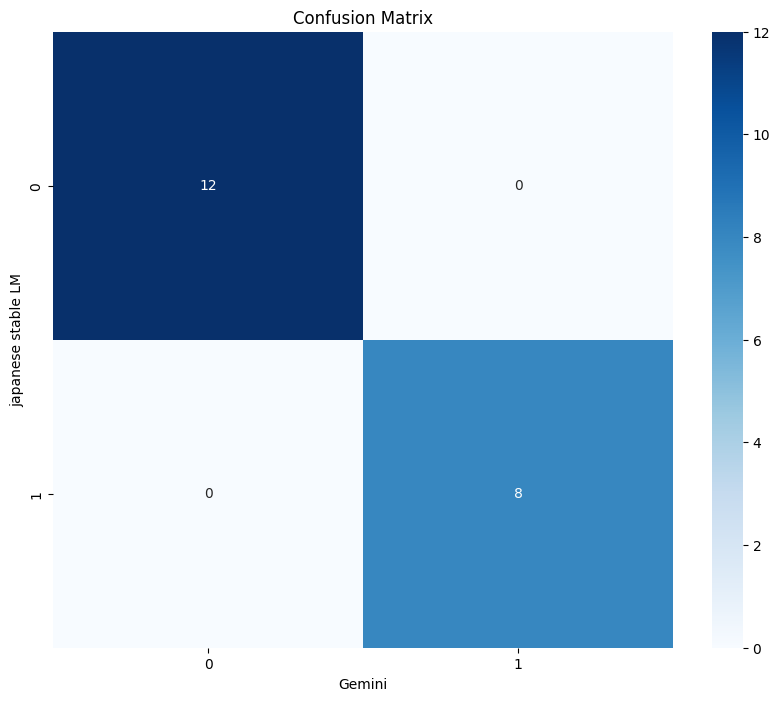

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_true))
plt.xlabel('Gemini')
plt.ylabel('japanese stable LM')
plt.title('Confusion Matrix')
plt.show()

#### ChatGPTによるセンチメント分析

In [ ]:
# GPT_MODEL = "gpt-3.5-turbo"
GPT_MODEL = "gpt-4o-mini-2024-07-18"

In [ ]:
def get_completion(prompt, model=GPT_MODEL):

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)

  return response.choices[0].message["content"]

In [ ]:
test_set_gpt = test_set
test_set_gpt['pred_label'] = ''
test_set_gpt

,review,label,clean_reviews,pred_label
531,This is the worst Amazon purchase I have made....,0,this is the worst amazon purchase have made am...,
1011,I am impressed with the sound quality.,1,am impressed with the sound quality,
299,Too difficult to set up. It keeps timing out ...,0,too difficult to set up it keeps timing out be...,
1059,Honestly I like it but at the same time I don’...,0,honestly like it but at the same time don coul...,
2172,Bought the 2nd firestick for bedroom. Easily i...,1,bought the 2nd firestick for bedroom easily in...,
1498,Easy to use!,1,easy to use,
2964,Ask it to play Motown radio on Pandora and it ...,0,ask it to play motown radio on pandora and it ...,
286,I’m impressed with the quality of sound that t...,1,impressed with the quality of sound that the e...,
2314,Ordered 2 on deal day. 1 doesn’t work and 2 nd...,0,ordered 2 on deal day 1 doesn work and 2 nd ju...,
3053,I'm addicted to this thing.,1,addicted to this thing,


In [ ]:
batches = []
batch_size = 50

for i in range(0, len(test_set_gpt), batch_size):
  batches.append(test_set_gpt[i : i + batch_size])

In [ ]:
openai.api_key  = OPENAI_API_KEY
model = GPT_MODEL

def get_completion(prompt, model="gpt-3.5-turbo"):

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)

  return response.choices[0].message["content"]

In [ ]:
import time

def gpt_completion_function(batch,current_batch,total_batch,model="gpt-3.5-turbo-1106"):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing the Gemini Prompt
  # Step-3: Calling GPT API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_reviews','pred_label']].to_json(orient='records')

  prompt = f"""You are a marketing expert, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {json_data}
  ```
  """

  print(prompt)

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)
  time.sleep(5)
  return response.choices[0].message["content"]

In [ ]:
batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gpt_completion_function(batches[i],i,batch_count))

Now processing batch#: 1 of 1
You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  [{"clean_reviews":"this is the worst amazon purchase have made am big amazon fan love the brand unlimited digital music prime videos even buy my online games music and movies through amazon this app have tried to use it make simple purchases to do anything it is useless","pred_label":""},{"clean_reviews":"am impressed with the 

In [ ]:
import json
import pandas as pd


df_gpt= pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Append the DataFrame to the final DataFrame
  df_gpt = pd.concat([df_gpt, df_temp], ignore_index=True)

test_set_gpt['pred_label'] =  df_gpt['pred_label'].values
test_set_gpt

,review,label,clean_reviews,pred_label
531,This is the worst Amazon purchase I have made....,0,this is the worst amazon purchase have made am...,0
1011,I am impressed with the sound quality.,1,am impressed with the sound quality,1
299,Too difficult to set up. It keeps timing out ...,0,too difficult to set up it keeps timing out be...,0
1059,Honestly I like it but at the same time I don’...,0,honestly like it but at the same time don coul...,0
2172,Bought the 2nd firestick for bedroom. Easily i...,1,bought the 2nd firestick for bedroom easily in...,1
1498,Easy to use!,1,easy to use,1
2964,Ask it to play Motown radio on Pandora and it ...,0,ask it to play motown radio on pandora and it ...,0
286,I’m impressed with the quality of sound that t...,1,impressed with the quality of sound that the e...,1
2314,Ordered 2 on deal day. 1 doesn’t work and 2 nd...,0,ordered 2 on deal day 1 doesn work and 2 nd ju...,0
3053,I'm addicted to this thing.,1,addicted to this thing,1


In [ ]:
y_true = test_set_gpt["label"]
y_pred = test_set_gpt["pred_label"]


#混同行列
conf_matrix=confusion_matrix(y_true, y_pred)
print(confusion_matrix(y_true, y_pred))
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")

[[12  0]
 [ 0  8]]

Accuracy: 1.0


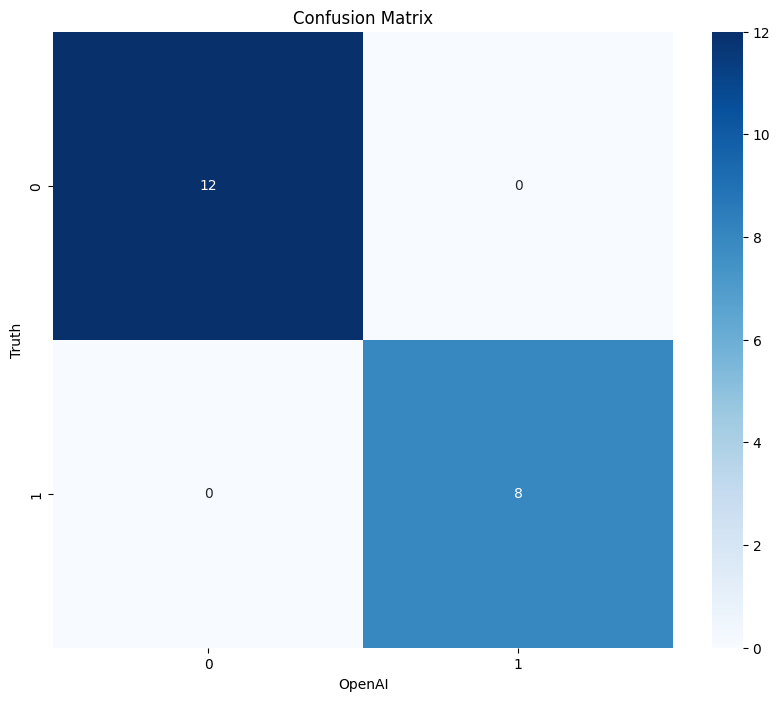

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_true))
plt.xlabel('OpenAI')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()